In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from datetime import datetime 
from IPython.display import display, HTML, clear_output, Image
import gc
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import pydotplus

In [2]:
r'''
dataset2019: all sumo data with ocupation (requested in sumo office)
'''

dataset2019_path = r'C:\Users\ing_l\Tesis grado\Data\dataset_2019.csv'

In [3]:
dataset2019 = pd.read_csv(dataset2019_path)[['id_cuadra', 'direccion', 'fecha', 'tiempo', 'operacion', 'ocupacion', 'latitud', 'longitud']]
dataset2019['dia de la semana'] = -1
dataset2019.columns.names = ['dataset2019']

In [4]:
def correct_type(row):
    '''
    Corrects the dtype of fecha, tiempo and ocupación on the df
    '''
    row['fecha'] = pd.to_datetime(row['fecha'], dayfirst=True).date()
    row['tiempo'] = pd.to_datetime(row['tiempo']).time()
    row['ocupacion'] = int(row['ocupacion'])
    row['dia de la semana'] = row['fecha'].weekday()
    return row

print('Working on dataset2019...')
dataset2019 = dataset2019.apply(correct_type, axis=1).sort_values(by=['fecha', 'tiempo'])
clear_output()

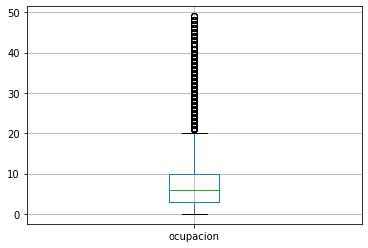

In [5]:
dataset2019['porcentaje ocupacion'] = 0
max_without_outliers = dataset2019.boxplot(column='ocupacion', return_type='dict')['whiskers'][1].get_ydata()[1]

grade_1 = dataset2019['ocupacion'] <= (max_without_outliers * 1/4)
grade_2 = (~grade_1) & (dataset2019['ocupacion'] <= (max_without_outliers * 2/4))
grade_3 = (~grade_1) & (~grade_2) & (dataset2019['ocupacion'] <= (max_without_outliers * 3/4))
grade_4 = (~grade_1) & (~grade_2) & (~grade_3) & (dataset2019['ocupacion'] <= (max_without_outliers))
grade_5 = (~grade_1) & (~grade_2) & (~grade_3) & (~grade_4)

dataset2019.loc[grade_1, 'porcentaje ocupacion'] = 0
dataset2019.loc[grade_2, 'porcentaje ocupacion'] = 1
dataset2019.loc[grade_3, 'porcentaje ocupacion'] = 2
dataset2019.loc[grade_4, 'porcentaje ocupacion'] = 3
dataset2019.loc[grade_5, 'porcentaje ocupacion'] = 4

In [6]:
dataset2019['mes'] = dataset2019['fecha'].apply(lambda x: x.month)
dataset2019['hora'] = dataset2019['tiempo'].apply(lambda x: x.hour)
dataset2019['timestamp'] = dataset2019['tiempo'].apply(lambda x: x.hour * 24 * 60 * 60+ x.minute * 60 + x.second)

In [7]:
dataset2019

dataset2019,id_cuadra,direccion,fecha,tiempo,operacion,ocupacion,latitud,longitud,dia de la semana,porcentaje ocupacion,mes,hora,timestamp
0,16,Belgrano 660,2019-01-01,10:55:00,0,0,-37.328838,-59.134455,1,0,1,10,1062000
7,1,General Pinto 545,2019-01-01,15:12:00,1,1,-37.327782,-59.136657,1,0,1,15,1339200
9,65,Rodriguez 348,2019-01-01,15:13:00,1,1,-37.329387,-59.134833,1,0,1,15,1342800
8,1,General Pinto 545,2019-01-01,15:15:00,0,0,-37.327782,-59.136657,1,0,1,15,1350000
10,65,Rodriguez 348,2019-01-01,16:22:00,0,0,-37.329387,-59.134833,1,0,1,16,1461600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2957257,18,Sarmiento 543,2019-12-31,19:45:00,1,4,-0.000000,-0.000000,1,0,12,19,1803600
2957258,18,Sarmiento 543,2019-12-31,19:46:00,0,3,-0.000000,-0.000000,1,0,12,19,1807200
2956381,24,Belgrano 364,2019-12-31,19:53:00,1,1,-37.330077,-59.138438,1,0,12,19,1832400
2956511,60,Chacabuco 357,2019-12-31,20:08:00,0,0,-37.330203,-59.137003,1,0,12,20,1756800


In [8]:
def print_balanced_classes(df):
    d = df.copy()
    d = d.groupby(by='operacion').count()[['id_cuadra']]
    d.rename(columns={'id_cuadra': 'Cantidad datos'}, inplace=True)
    if pow(pow(d.iloc[0].values - d.iloc[1].values, 2), 0.5) > (len(df) * 0.4):
        print('Clases no balanceadas.')
    else:
        print('Clases balanceadas.')
    display(d)
    
print_balanced_classes(dataset2019)

Clases balanceadas.


dataset2019,Cantidad datos
operacion,
0,1477989
1,1479553


## Con todos los datos juntos

In [9]:
data = dataset2019.copy()

In [40]:
max_depth = 20
train_columns = ['id_cuadra', 'mes', 'dia de la semana', 'hora', 'ocupacion']

In [41]:
best_score = np.zeros((max_depth+1, 2))
best_depth = 0
best_model = 0


for i in range(1, max_depth+1):
    
    x = data[train_columns].to_numpy()[:-1]
    y = data['operacion'].to_numpy()[1:]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)

    dt = DecisionTreeClassifier(max_depth=i)
    dt = dt.fit(x_train, y_train)
    
    if dt.score(x_test, y_test) > max([x[1] for x in best_score]):
        best_depth = i
        best_model = dt
        
    best_score[i][0] = dt.score(x_train, y_train)
    best_score[i][1] = dt.score(x_test, y_test)

print(best_depth)
print(best_score)

8
[[0.         0.        ]
 [0.55421011 0.55436776]
 [0.55410771 0.55460669]
 [0.55450717 0.55411755]
 [0.57061371 0.57024693]
 [0.57044078 0.57065605]
 [0.57039634 0.57079017]
 [0.57113151 0.57020297]
 [0.57067602 0.57127932]
 [0.57147398 0.57058167]
 [0.57116484 0.57126805]
 [0.57160681 0.57035963]
 [0.57186764 0.57057039]
 [0.57261972 0.56971834]
 [0.57329064 0.56910071]
 [0.57390408 0.56871525]
 [0.5745953  0.56816299]
 [0.57537152 0.5685214 ]
 [0.5762656  0.5666764 ]
 [0.57667859 0.56721401]
 [0.57841459 0.56509851]]


In [42]:
max([x[1] for x in best_score])

0.5712793162793895

In [23]:
# Create DOT data
dot_data = export_graphviz(best_model, 
                        out_file=None,
                        impurity = True,
                        feature_names = ['id_cuadra', 'mes', 'dia de la semana', 'hora', 'ocupacion'],
                        class_names = ['Salida', 'Entrada'],
                        rounded = True,
                        filled= True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

ValueError: Length of feature_names, 5 does not match number of features, 2

In [43]:
gc.collect()

325

## Separando por calles

In [44]:
data = dataset2019.copy()

In [45]:
max_depth = 15

In [46]:
mid_score = np.zeros((len(dataset2019['id_cuadra'].drop_duplicates())+1, 2))
mid_model = np.zeros(len(dataset2019['id_cuadra'].drop_duplicates())+1)

best_street_scores = np.zeros((len(dataset2019['id_cuadra'].drop_duplicates())+1, 2))

best_score = np.zeros((max_depth+1, 2))
best_depth = 0
best_model = np.array(len(dataset2019['id_cuadra'].drop_duplicates())+1)

for i in range(1, max_depth+1):
    index = 0 
    for s in dataset2019['id_cuadra'].drop_duplicates():
        
        #clear_output()
        #print('Index:', index)
        
        d = data.loc[data['id_cuadra'] == s]
        
        x = d[train_columns].to_numpy()[:-1]
        y = d['operacion'].to_numpy()[1:]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True, stratify=y)
        
        dt = DecisionTreeClassifier(max_depth=i)
        dt = dt.fit(x_train, y_train)
                     
        mid_score[index][0] = dt.score(x_train, y_train)
        mid_score[index][1] = dt.score(x_test, y_test)
        
        index+=1
    
    if (sum([x[1] for x in mid_score]) / len(mid_score)) > max([x[1] for x in best_score]):
        best_depth = i
        best_street_scores = mid_score.copy()
        #best_model = mid_model
        
    best_score[i][0] = (sum([x[0] for x in mid_score]) / len(mid_score))
    best_score[i][1] = (sum([x[1] for x in mid_score]) / len(mid_score))
    
    
clear_output()

print(best_depth)
#print(best_min_samples)
print(best_score)

8
[[0.         0.        ]
 [0.56432432 0.56309223]
 [0.57208146 0.57077902]
 [0.5855197  0.58404   ]
 [0.59017886 0.5863257 ]
 [0.59462674 0.59190268]
 [0.59808573 0.59410126]
 [0.60045717 0.59435529]
 [0.60125006 0.59497731]
 [0.60280248 0.59309606]
 [0.60347774 0.59322792]
 [0.60431739 0.59261046]
 [0.60454639 0.59234711]
 [0.6040297  0.59364137]
 [0.60490555 0.59147706]
 [0.60470813 0.59161443]]


In [47]:
print(max([x[1] for x in best_score]))
print('')
print(best_street_scores)

0.5949773136081491

[[0.57114944 0.56815329]
 [0.58420554 0.57894091]
 [0.60172926 0.59718428]
 [0.58578829 0.58052795]
 [0.58005818 0.57279402]
 [0.57912997 0.56934932]
 [0.5986832  0.58568536]
 [0.57797655 0.56915614]
 [0.58979136 0.58849883]
 [0.68646865 0.68094321]
 [0.59727741 0.58931104]
 [0.57135722 0.57058504]
 [0.57173326 0.57392458]
 [0.61529791 0.60674368]
 [0.58287217 0.56950549]
 [0.60731871 0.59227356]
 [0.58057502 0.57461545]
 [0.59348793 0.59002388]
 [0.60038397 0.59345731]
 [0.5805161  0.56722271]
 [0.65468584 0.64037267]
 [0.60858077 0.59766385]
 [0.59179688 0.59275314]
 [0.59191542 0.58536585]
 [0.57274907 0.56832725]
 [0.61548607 0.60923077]
 [0.59703222 0.58663162]
 [0.57406627 0.5635696 ]
 [0.6149914  0.6076683 ]
 [0.62480173 0.61116717]
 [0.58963096 0.58450941]
 [0.58439295 0.57782031]
 [0.61086753 0.60321986]
 [0.59173815 0.57811893]
 [0.59740991 0.58281336]
 [0.61117019 0.61706556]
 [0.58684874 0.5812278 ]
 [0.57950042 0.57770089]
 [0.59796216 0.59290815]
 [0.6

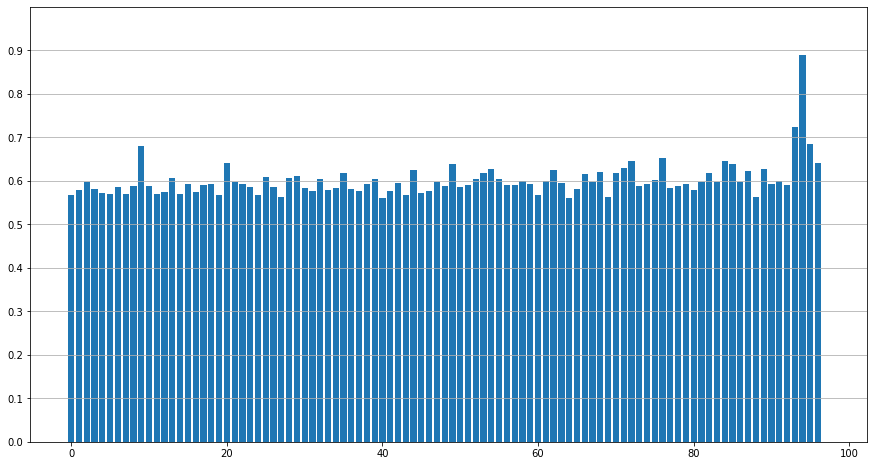

In [48]:
height = [x for x in range(len(best_street_scores))]
total_prob_plot = [x[1] for x in best_street_scores]
plt.bar(height, total_prob_plot)
plt.rcParams['figure.figsize'] = (15,8)

plt.yticks([x for x in np.arange(0, 1, 0.1)])
#plt.xticks(height)
plt.ylim(0, 1)
plt.grid(axis='y')

In [ ]:
# Create DOT data
dot_data = export_graphviz(best_model[0], 
                        out_file=None,
                        impurity = True,
                        feature_names = ['mes', 'dia de la semana', 'hora', 'ocupacion'],
                        class_names = ['Salida', 'Entrada'],
                        rounded = True,
                        filled= True)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [39]:
gc.collect()

9195